# Clean that twitter data!

Use of the "Table of Contents" nbextension is highly recommended.

### Basic imports, settings

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import os
import json
import sys
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth',100)

### Check variables in memory

In [3]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('np', 80), ('pd', 80), ('plt', 80), ('dir_path', 68)]

## Read data

In [5]:
file_name

'data_merged.csv'

In [6]:
dir_path = '../data/tweets_maga'
data = pd.DataFrame()

print('Loading tweets from', dir_path)
file_names = [file for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
for file_name in file_names:
    
    if file_name == 'data_merged.csv':
        continue
        
    file_path = dir_path + '/' + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        tweets = pd.read_json(file)
        data = pd.concat([data, tweets], ignore_index=True)
        
print('Successfully loaded {} tweets from {} files.'.format(len(data), len(file_names)))

Loading tweets from ../data/tweets_maga
Successfully loaded 50000 tweets from 51 files.


In [7]:
original_text = data.text
original_text

0        @realDonaldTrump I’m confused. Is this a new “greatest” or the same as the old? All of your scan...
1                            @realDonaldTrump @Hyundai @Kia @Aptiv I'm not yet tired of winning, Sir!  #MAGA
2        @WA_Silenced_Maj @realDonaldTrump You are the true patriots!  If Antifa physically assaults you ...
3        It is amazing to watch @RudyGiuliani throw his reputation down the toilet. My guess @realDonaldT...
4                     @w_terrence @realDonaldTrump WHOOOOOHOOOOO! I’m so excited for you! #MAGA #KAG2020♥️🇺🇸
5        #Trump LIED ABOUT WIKILEAKS in #MuellerReport\n\nThe grand-jury REDACTIONS in special counsel #M...
6                               Never polled and don't know anyone that has. \n#MAGA https://t.co/n1bzaxntWX
7        #GettumGirl\n\n#Maga needs to get off their ass and put their foot down!\n\nDems/Antifa (same th...
8                                                                   @realDonaldTrump Beautiful!\n#KAG\n#MAGA
9        #RedOctobe

## Clean data

### Lower case, strip

In [8]:
# everything in lower case, strip
data['text'] = data.text.str.lower()
data['text'] = data.text.str.strip()

### Remove tags, usernames, hyperlinks

In [9]:
# remove every #tag 
data['text'] = data.text.str.replace(r'#\S*', '')

In [10]:
# remove every @username
data['text'] = data.text.str.replace(r'@\S*', '')

In [11]:
# remove links
data['text'] = data.text.str.replace(r'http(\S)*', '')

### Remove punctuation

In [12]:
# side note: f*ck those wierdly encoded characters, I'm gonna deal with them in another way... :@
data['text'] = data.text.str.replace(r'[\.,;:?!\(\)\n\t]','')

In [13]:
data.text

0         i’m confused is this a new “greatest” or the same as the old all of your scandals are hard to f...
1                                                                         i'm not yet tired of winning sir  
2          you are the true patriots  if antifa physically assaults you in any way you can legally defend...
3        it is amazing to watch  throw his reputation down the toilet my guess  has something on him or m...
4                                                                     whooooohooooo i’m so excited for you  
5         lied about wikileaks in the grand-jury redactions in special counsel  report show that presiden...
6                                                              never polled and don't know anyone that has  
7                 needs to get off their ass and put their foot downdems/antifa same thing crossed the line 
8                                                                                                  beautiful
9                  

### Tokenize

In [14]:
from nltk.tokenize import TweetTokenizer

# strip_handles because I'm not sure what it does (maybe removes usernames?),
# reduce_len because I want 'waaaaaay' to be equal to 'waaay'
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

In [57]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tandemelephant/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [58]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
# stemmer = LancasterStemmer()

[stemmer.stem(lemmatizer.lemmatize(word, pos='v')) for word in ['lier','lieing','lied','running','runner','breaker','competition','hacker']]

['lier', 'lie', 'lie', 'run', 'runner', 'breaker', 'competit', 'hacker']

In [75]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

def token_cleaner(token_list):
    
    stemmer = SnowballStemmer('english')
    
    stop_words = set(stopwords.words('english'))
    # add custom filters
    stop_words.add('amp')
    
    # return words with 2 or more letters
    regex = re.compile(r'[a-z_][a-z_-][a-z_-]+')
    
    tokens = [x for x in token_list if x not in stop_words]
    return list(filter(regex.match, [stemmer.stem(x) for x in tokens]))

In [91]:
data['tokens'] = data.text.apply(tokenizer.tokenize).apply(token_cleaner)

In [93]:
from collections import Counter

exclude_word_frequency_threshold = 4

all_words = [word for sublist in data.tokens.values for word in sublist ]
word_counts = sorted(list(Counter(all_words).items()), reverse=True, key=lambda tup: tup[1])
exclude_words = set([word for word, count in word_counts if count < exclude_word_frequency_threshold])
print(f'Unique words, all / to be excluded: {len(word_counts)} / {len(exclude_words)}')

Unique words, all / to be excluded: 29305 / 22120


In [94]:
data['tokens'] = data.tokens.apply(lambda l: [word for word in l if word not in exclude_words])

In [97]:
data[['text','tokens']]

,text,tokens
0,i’m confused is this a new “greatest” or the same as the old all of your scandals are hard to f...,"[confus, new, greatest, old, scandal, hard, follow]"
1,i'm not yet tired of winning sir,"[yet, tire, win, sir]"
2,you are the true patriots if antifa physically assaults you in any way you can legally defend...,"[true, patriot, antifa, physic, assault, way, legal, defend]"
3,it is amazing to watch throw his reputation down the toilet my guess has something on him or m...,"[amaz, watch, throw, reput, toilet, guess, someth, mayb, bumbl, old, fool, hard, tell]"
4,whooooohooooo i’m so excited for you,[excit]
5,lied about wikileaks in the grand-jury redactions in special counsel report show that presiden...,"[lie, wikileak, redact, special, counsel, report, show, presid, trump, lie, knowledg, campaign, ..."
6,never polled and don't know anyone that has,"[never, poll, know, anyon]"
7,needs to get off their ass and put their foot downdems/antifa same thing crossed the line,"[need, get, ass, put, foot, antifa, thing, cross, line]"
8,beautiful,[beauti]
9,did mean this october maybe is onto something regarding this horrible excuse 👇👇👇,"[mean, octob, mayb, onto, someth, regard, horribl, excus]"


## Save data

In [98]:
data.to_csv(dir_path + '/' + 'data_merged.csv')

## Wordcloud

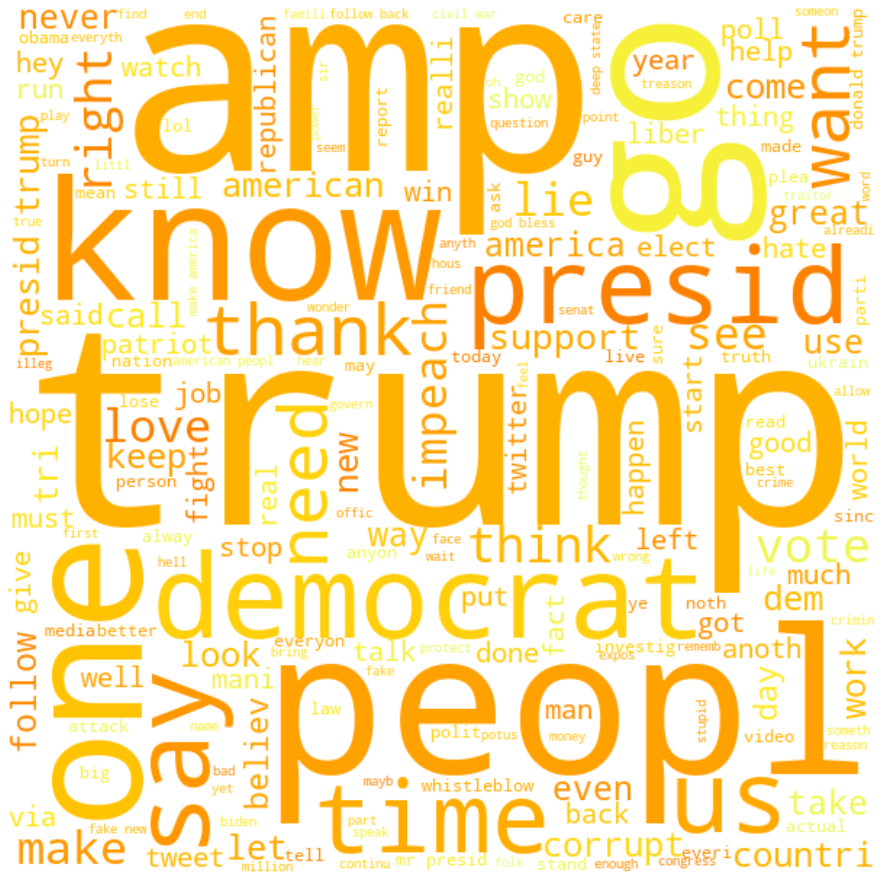

In [119]:
from wordcloud import WordCloud
all_words = [word for sublist in data.tokens.values for word in sublist ]
word_cloud = WordCloud(width = 600, height=600, background_color='white', colormap='Wistia').generate(' '.join(all_words))

fig, ax = plt.subplots(figsize=(16,16))

ax.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.savefig('../img/maga_cloud.png', facecolor='white')
plt.show()